# Timeseries classification from scratch

**Author:** [hfawaz](https://github.com/hfawaz/), [Vijay Yalamanchili](https://github.com/vijaykrishnay/)<br>
**Date created:** 2020/07/21<br>
**Last modified:** 2020/12/15<br>
**Description:** Training a timeseries classifier from scratch on the FordA dataset from the UCR/UEA archive.

## Introduction

This example shows how to do timeseries classification from scratch, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).

## Setup

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [3]:
x_train

array([[-0.79717168, -0.66439208, -0.37301463, ..., -0.66439208,
        -1.0737958 , -1.5643427 ],
       [ 0.80485472,  0.63462859,  0.37347448, ..., -0.71488505,
        -0.56044294, -0.31908642],
       [ 0.7279851 ,  0.11128392, -0.49912439, ...,  0.39446303,
         0.33940042,  0.25539062],
       ...,
       [-0.57005428, -0.33316523, -0.29351853, ..., -1.3937145 ,
        -0.94273327, -0.27072168],
       [ 2.0067321 ,  2.0791499 ,  2.0220362 , ..., -0.43214504,
        -0.44123126, -0.28070891],
       [-0.12524091, -0.32536268, -0.48823697, ...,  0.55576053,
         0.57445102,  0.57311598]])

## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

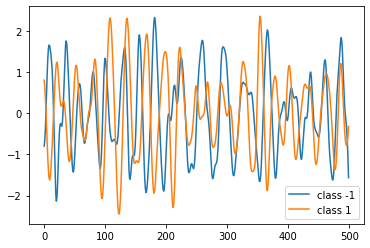

In [4]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardize the data

Our timeseries are already in a single length (176). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [5]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [6]:
num_classes = len(np.unique(y_train))

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [7]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [8]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).

In [9]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    lstm1 = keras.layers.LSTM(32, return_sequences=False)(input_layer)
    lstm1 = keras.layers.BatchNormalization()(lstm1)
    lstm1 = keras.layers.Dropout(0.2)(lstm1)
    
#     lstm2 = keras.layers.LSTM(32, return_sequences=False)(lstm1)
#     lstm2 = keras.layers.BatchNormalization()(lstm2)
#     lstm2 = keras.layers.Dropout(0.2)(lstm2)
    
    dense1 = keras.layers.Dense(8, activation="relu")(lstm1)
    
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(dense1)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
Total params: 4,762
Trainable params: 4,698
Non-trainable params: 64
__________________________________________________________

## Train the model

In [10]:
epochs = 500
batch_size = 32
learning_rate = 0.0005
model_name = "best_model_lstm.h5"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        model_name, save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=15, min_lr=0.00005
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1),
]
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
#     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 8s 71ms/step - loss: 0.7549 - sparse_categorical_accuracy: 0.4954 - val_loss: 0.6918 - val_sparse_categorical_accuracy: 0.5326
Epoch 2/500
90/90 [==============================] - 6s 63ms/step - loss: 0.7144 - sparse_categorical_accuracy: 0.5128 - val_loss: 0.6913 - val_sparse_categorical_accuracy: 0.5326
Epoch 3/500
90/90 [==============================] - 6s 63ms/step - loss: 0.7043 - sparse_categorical_accuracy: 0.5150 - val_loss: 0.6913 - val_sparse_categorical_accuracy: 0.5326
Epoch 4/500
90/90 [==============================] - 6s 63ms/step - loss: 0.6995 - sparse_categorical_accuracy: 0.5255 - val_loss: 0.6911 - val_sparse_categorical_accuracy: 0.5312
Epoch 5/500
90/90 [==============================] - 6s 63ms/step - loss: 0.6987 - sparse_categorical_accuracy: 0.5210 - val_loss: 0.6896 - val_sparse_categorical_accuracy: 0.5381
Epoch 6/500
90/90 [==============================] - 6s 63ms/step - loss: 0.7147 - sparse_categorica

90/90 [==============================] - 5s 61ms/step - loss: 0.3760 - sparse_categorical_accuracy: 0.8290 - val_loss: 3.8445 - val_sparse_categorical_accuracy: 0.5659
Epoch 47/500
90/90 [==============================] - 6s 61ms/step - loss: 0.3742 - sparse_categorical_accuracy: 0.8283 - val_loss: 2.3390 - val_sparse_categorical_accuracy: 0.6338
Epoch 48/500
90/90 [==============================] - 6s 62ms/step - loss: 0.3675 - sparse_categorical_accuracy: 0.8243 - val_loss: 2.6351 - val_sparse_categorical_accuracy: 0.6047
Epoch 49/500
90/90 [==============================] - 6s 61ms/step - loss: 0.3436 - sparse_categorical_accuracy: 0.8293 - val_loss: 1.2178 - val_sparse_categorical_accuracy: 0.6463
Epoch 50/500
90/90 [==============================] - 6s 62ms/step - loss: 0.3521 - sparse_categorical_accuracy: 0.8287 - val_loss: 1.8622 - val_sparse_categorical_accuracy: 0.6061
Epoch 51/500
90/90 [==============================] - 5s 61ms/step - loss: 0.3340 - sparse_categorical_accur

90/90 [==============================] - 5s 61ms/step - loss: 0.2338 - sparse_categorical_accuracy: 0.9061 - val_loss: 0.1998 - val_sparse_categorical_accuracy: 0.9293
Epoch 92/500
90/90 [==============================] - 5s 61ms/step - loss: 0.2277 - sparse_categorical_accuracy: 0.9083 - val_loss: 0.2000 - val_sparse_categorical_accuracy: 0.9251
Epoch 93/500
90/90 [==============================] - 5s 61ms/step - loss: 0.2186 - sparse_categorical_accuracy: 0.9110 - val_loss: 0.2127 - val_sparse_categorical_accuracy: 0.9265
Epoch 94/500
90/90 [==============================] - 5s 61ms/step - loss: 0.2233 - sparse_categorical_accuracy: 0.9090 - val_loss: 0.1900 - val_sparse_categorical_accuracy: 0.9237
Epoch 95/500
90/90 [==============================] - 5s 61ms/step - loss: 0.2080 - sparse_categorical_accuracy: 0.9171 - val_loss: 0.2020 - val_sparse_categorical_accuracy: 0.9376
Epoch 96/500
90/90 [==============================] - 5s 61ms/step - loss: 0.1757 - sparse_categorical_accur

90/90 [==============================] - 5s 58ms/step - loss: 0.1859 - sparse_categorical_accuracy: 0.9233 - val_loss: 0.1830 - val_sparse_categorical_accuracy: 0.9390
Epoch 137/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.9343 - val_loss: 0.2695 - val_sparse_categorical_accuracy: 0.8974
Epoch 138/500
90/90 [==============================] - 5s 59ms/step - loss: 0.1888 - sparse_categorical_accuracy: 0.9288 - val_loss: 0.2193 - val_sparse_categorical_accuracy: 0.9251
Epoch 139/500
90/90 [==============================] - 5s 59ms/step - loss: 0.1708 - sparse_categorical_accuracy: 0.9366 - val_loss: 0.1591 - val_sparse_categorical_accuracy: 0.9417
Epoch 140/500
90/90 [==============================] - 5s 59ms/step - loss: 0.1793 - sparse_categorical_accuracy: 0.9256 - val_loss: 0.1702 - val_sparse_categorical_accuracy: 0.9417
Epoch 141/500
90/90 [==============================] - 5s 58ms/step - loss: 0.1530 - sparse_categorical_

90/90 [==============================] - 5s 60ms/step - loss: 0.1530 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.1654 - val_sparse_categorical_accuracy: 0.9445
Epoch 182/500
90/90 [==============================] - 5s 58ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.9396 - val_loss: 0.1666 - val_sparse_categorical_accuracy: 0.9445
Epoch 183/500
90/90 [==============================] - 5s 59ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.9355 - val_loss: 0.1552 - val_sparse_categorical_accuracy: 0.9445
Epoch 184/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1567 - sparse_categorical_accuracy: 0.9378 - val_loss: 0.1563 - val_sparse_categorical_accuracy: 0.9431
Epoch 185/500
90/90 [==============================] - 5s 59ms/step - loss: 0.1631 - sparse_categorical_accuracy: 0.9390 - val_loss: 0.1604 - val_sparse_categorical_accuracy: 0.9390
Epoch 186/500
90/90 [==============================] - 5s 59ms/step - loss: 0.1583 - sparse_categorical_

90/90 [==============================] - 5s 59ms/step - loss: 0.1507 - sparse_categorical_accuracy: 0.9382 - val_loss: 0.1695 - val_sparse_categorical_accuracy: 0.9445
Epoch 227/500
90/90 [==============================] - 5s 59ms/step - loss: 0.1616 - sparse_categorical_accuracy: 0.9411 - val_loss: 0.1549 - val_sparse_categorical_accuracy: 0.9431
Epoch 228/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1575 - sparse_categorical_accuracy: 0.9392 - val_loss: 0.1601 - val_sparse_categorical_accuracy: 0.9473
Epoch 229/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.9458 - val_loss: 0.2017 - val_sparse_categorical_accuracy: 0.9320
Epoch 230/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1612 - sparse_categorical_accuracy: 0.9398 - val_loss: 0.1537 - val_sparse_categorical_accuracy: 0.9445
Epoch 231/500
90/90 [==============================] - 5s 58ms/step - loss: 0.1808 - sparse_categorical_

90/90 [==============================] - 5s 60ms/step - loss: 0.1403 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.1517 - val_sparse_categorical_accuracy: 0.9473
Epoch 272/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1606 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.1995 - val_sparse_categorical_accuracy: 0.9417
Epoch 273/500
90/90 [==============================] - 5s 61ms/step - loss: 0.1420 - sparse_categorical_accuracy: 0.9439 - val_loss: 0.2251 - val_sparse_categorical_accuracy: 0.9196
Epoch 274/500
90/90 [==============================] - 5s 61ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.9409 - val_loss: 0.1512 - val_sparse_categorical_accuracy: 0.9473
Epoch 275/500
90/90 [==============================] - 6s 62ms/step - loss: 0.1406 - sparse_categorical_accuracy: 0.9484 - val_loss: 0.1960 - val_sparse_categorical_accuracy: 0.9307
Epoch 276/500
90/90 [==============================] - 5s 61ms/step - loss: 0.1430 - sparse_categorical_

90/90 [==============================] - 5s 60ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.9371 - val_loss: 0.1505 - val_sparse_categorical_accuracy: 0.9515
Epoch 317/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.9441 - val_loss: 0.1571 - val_sparse_categorical_accuracy: 0.9501
Epoch 318/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.9373 - val_loss: 0.1795 - val_sparse_categorical_accuracy: 0.9459
Epoch 319/500
90/90 [==============================] - 5s 61ms/step - loss: 0.1550 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.1746 - val_sparse_categorical_accuracy: 0.9376
Epoch 320/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1558 - sparse_categorical_accuracy: 0.9372 - val_loss: 0.1495 - val_sparse_categorical_accuracy: 0.9515
Epoch 321/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1426 - sparse_categorical_

90/90 [==============================] - 5s 57ms/step - loss: 0.1437 - sparse_categorical_accuracy: 0.9447 - val_loss: 0.1616 - val_sparse_categorical_accuracy: 0.9417
Epoch 362/500
90/90 [==============================] - 5s 57ms/step - loss: 0.1549 - sparse_categorical_accuracy: 0.9381 - val_loss: 0.1592 - val_sparse_categorical_accuracy: 0.9487
Epoch 363/500
90/90 [==============================] - 5s 59ms/step - loss: 0.1435 - sparse_categorical_accuracy: 0.9504 - val_loss: 0.1650 - val_sparse_categorical_accuracy: 0.9445
Epoch 364/500
90/90 [==============================] - 5s 58ms/step - loss: 0.1349 - sparse_categorical_accuracy: 0.9507 - val_loss: 0.1604 - val_sparse_categorical_accuracy: 0.9487
Epoch 365/500
90/90 [==============================] - 5s 58ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.9463 - val_loss: 0.1560 - val_sparse_categorical_accuracy: 0.9459
Epoch 366/500
90/90 [==============================] - 5s 58ms/step - loss: 0.1552 - sparse_categorical_

90/90 [==============================] - 5s 60ms/step - loss: 0.1542 - sparse_categorical_accuracy: 0.9324 - val_loss: 0.1549 - val_sparse_categorical_accuracy: 0.9459
Epoch 407/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1684 - sparse_categorical_accuracy: 0.9356 - val_loss: 0.1747 - val_sparse_categorical_accuracy: 0.9390
Epoch 408/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1561 - sparse_categorical_accuracy: 0.9381 - val_loss: 0.1521 - val_sparse_categorical_accuracy: 0.9515
Epoch 409/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.9501 - val_loss: 0.2156 - val_sparse_categorical_accuracy: 0.9376
Epoch 410/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1550 - sparse_categorical_accuracy: 0.9426 - val_loss: 0.1607 - val_sparse_categorical_accuracy: 0.9459
Epoch 411/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1527 - sparse_categorical_

90/90 [==============================] - 5s 60ms/step - loss: 0.1537 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.1643 - val_sparse_categorical_accuracy: 0.9473
Epoch 452/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1538 - sparse_categorical_accuracy: 0.9385 - val_loss: 0.1599 - val_sparse_categorical_accuracy: 0.9487
Epoch 453/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1431 - sparse_categorical_accuracy: 0.9467 - val_loss: 0.1504 - val_sparse_categorical_accuracy: 0.9556
Epoch 454/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1489 - sparse_categorical_accuracy: 0.9423 - val_loss: 0.1867 - val_sparse_categorical_accuracy: 0.9473
Epoch 455/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1602 - sparse_categorical_accuracy: 0.9390 - val_loss: 0.1499 - val_sparse_categorical_accuracy: 0.9528
Epoch 456/500
90/90 [==============================] - 5s 61ms/step - loss: 0.1458 - sparse_categorical_

90/90 [==============================] - 5s 61ms/step - loss: 0.1526 - sparse_categorical_accuracy: 0.9439 - val_loss: 0.1622 - val_sparse_categorical_accuracy: 0.9404
Epoch 497/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.9447 - val_loss: 0.1746 - val_sparse_categorical_accuracy: 0.9459
Epoch 498/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1600 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.1593 - val_sparse_categorical_accuracy: 0.9473
Epoch 499/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1542 - sparse_categorical_accuracy: 0.9414 - val_loss: 0.1552 - val_sparse_categorical_accuracy: 0.9487
Epoch 500/500
90/90 [==============================] - 5s 60ms/step - loss: 0.1510 - sparse_categorical_accuracy: 0.9388 - val_loss: 0.1585 - val_sparse_categorical_accuracy: 0.9515


## Evaluate model on test data

In [11]:
model = keras.models.load_model(model_name)

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 1s 19ms/step - loss: 0.1605 - sparse_categorical_accuracy: 0.9348
Test accuracy 0.9348484873771667
Test loss 0.16048568487167358


## Plot the model's training and validation loss

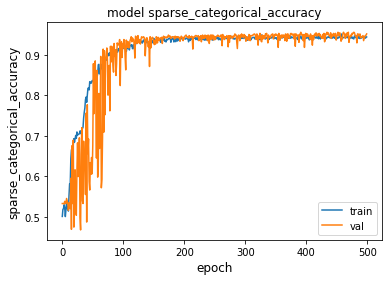

In [12]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

We can see how the training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.